In [27]:
# Images
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug
import cv2

# Toolbox
from pathlib import Path
from imutils import paths
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Misc
import random
import glob
import shutil
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

# Deep learning
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications import VGG16, MobileNetV2, InceptionV3
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.applications import inception_v3

# Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
def plot_history(model):
    acc = model.history['acc']
    val_acc = model.history['val_acc']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

In [3]:
base_dir = 'images/split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

nb_train_samples = 2000
nb_test_samples = 1000
nb_validation_samples = 1000
epochs = 5
batch_size = 32
image_size = 299

In [4]:
# Rescale all images by 1./255 and apply image augmentation
train_datagen = ImageDataGenerator(
                rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model InceptionV3
base_model = InceptionV3(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
# Add in new top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [7]:
# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
len(model.trainable_weights)

2

In [9]:
epochs=10
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
125/125 [==============================] - 26s 211ms/step - loss: 0.2944 - acc: 0.9052 - val_loss: 0.1783 - val_acc: 0.9330
Epoch 2/10
125/125 [==============================] - 22s 179ms/step - loss: 0.1318 - acc: 0.9590 - val_loss: 0.1035 - val_acc: 0.9675
Epoch 3/10
125/125 [==============================] - 22s 175ms/step - loss: 0.1094 - acc: 0.9627 - val_loss: 0.0739 - val_acc: 0.9792
Epoch 4/10
125/125 [==============================] - 23s 181ms/step - loss: 0.0884 - acc: 0.9710 - val_loss: 0.1113 - val_acc: 0.9614
Epoch 5/10
125/125 [==============================] - 23s 182ms/step - loss: 0.0874 - acc: 0.9665 - val_loss: 0.0924 - val_acc: 0.9700
Epoch 6/10
125/125 [==============================] - 23s 180ms/step - loss: 0.0771 - acc: 0.9723 - val_loss: 0.1312 - val_acc: 0.9527
Epoch 7/10
125/125 [==============================] - 22s 180ms/step - loss: 0.0686 - acc: 0.9762 - val_loss: 0.1012 - val_acc: 0.9665
Epoch 8

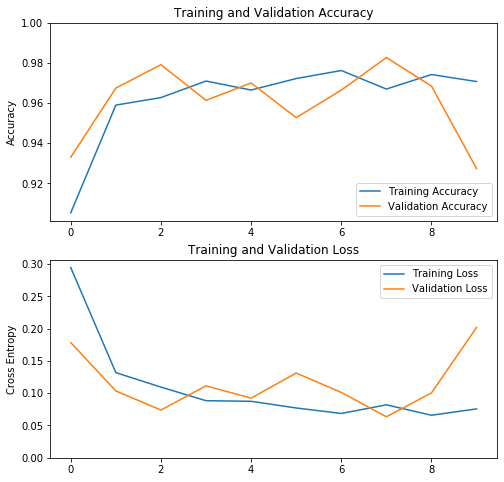

In [10]:
plot_history(history)

### Fine-tuning (Part 2)
The top layers are well trained and we can start fine-tuning convolutional layers from inception V3. We will freeze the bottom N layers and train the remaining top layers.

In [11]:
# Visualize layer names and layer indices to see how many layers we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [12]:
# We chose to train the top 2 inception blocks, i.e. we will freeze the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

Recompile the model for these modifications to take effect


In [13]:
# SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [157]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=50,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/50
125/125 [==============================] - 22s 175ms/step - loss: 0.0344 - acc: 0.9900 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 2/50
125/125 [==============================] - 22s 174ms/step - loss: 0.0294 - acc: 0.9920 - val_loss: 0.0068 - val_acc: 1.0000
Epoch 3/50
125/125 [==============================] - 22s 175ms/step - loss: 0.0300 - acc: 0.9903 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 4/50
125/125 [==============================] - 22s 175ms/step - loss: 0.0267 - acc: 0.9938 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 5/50
125/125 [==============================] - 22s 178ms/step - loss: 0.0248 - acc: 0.9918 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 6/50
125/125 [==============================] - 22s 178ms/step - loss: 0.0252 - acc: 0.9940 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 7/50
125/125 [==============================] - 22s 179ms/step - loss: 0.0260 - acc: 0.9925 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 8/50
125/125 [==============================] - 2

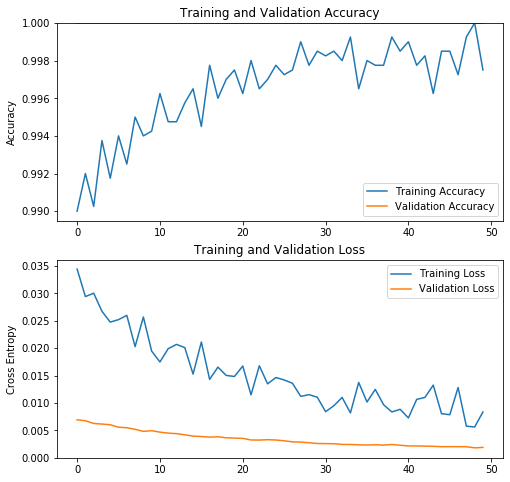

In [158]:
plot_history(history_fine)

In [38]:
# Serialize model to JSON
model_json = model.to_json()
with open('model_inceptionv3.json', 'w') as json_file:
    json_file.write(model_json)
    
# Serialize weights to HDF5
model.save_weights('model_weights_inceptionv3.h5')
print('Saved model to disk')

Saved model to disk


In [39]:
# Save model and architecture to single file
model.save('model_inceptionv3_full.h5')

In [ ]:
# # Load json and create model
# json_file = open('model_inceptionv3.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()

# loaded_model = model_from_json(loaded_model_json)

# # Load weights into new model
# loaded_model.load_weights('model_inceptionv3.h5')
# print("Loaded model from disk")

In [ ]:
# # Load model
# model = load_model('model_inceptionv3.h5')

# # Summarize model
# model.summary()

array([[1.]], dtype=float32)

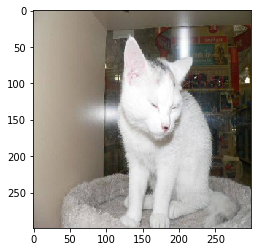

In [37]:
img_pred_path = 'images/original_test/34.jpg'
img_pred = load_img(img_pred_path, target_size=(299, 299))
plt.imshow(img_pred)
img_arr = img_to_array(img_pred)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr = preprocess_input(img_arr)
preds = model.predict(img_arr)
preds
# print('Predicted:', inception_v3.decode_predictions(preds, top=3)[0])

In [ ]:
# # Evaluate loaded model on test data
# loaded_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
#                      loss='binary_crossentropy',
#                      metrics=['accuracy'])

# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

----------

### Testing - Multiple images plotting

In [74]:
test_path = 'images/original_test'

In [ ]:
images = []

for img in os.listdir(test_path)[0:9]:
    print(img)
    img = load_img(os.path.join(test_path, img), target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)
    
images = np.vstack(images)    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


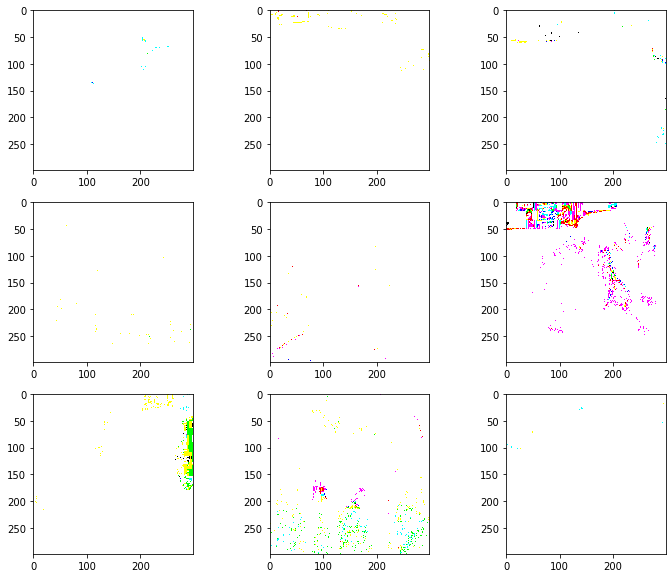

In [76]:
plt.figure(figsize=(12,10))
x, y = 3, 3
for i in range(9):  
    plt.subplot(y, x, i+1)
    plt.imshow(images[i])
plt.show()

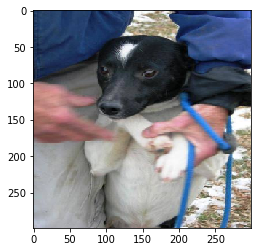

In [85]:
img_pred_path1 = 'images/original_test/1.jpg'
img_pred_path2 = 'images/original_test/2.jpg'
img_pred = load_img(img_pred_path, target_size=(299, 299))
img_pred2 = load_img(img_pred_path2, target_size=(299, 299))
plt.imshow(img_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


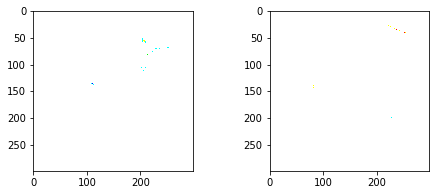

In [98]:
plt.figure(figsize=(12,10))
x, y = 3, 3

pred_images_list = [img_pred_path1, img_pred_path2]
for i in range(2):
    img = load_img(pred_images_list[i], target_size=(299, 299))
    img = img_to_array(img)
    plt.subplot(y, x, i+1)
    plt.imshow(img)
plt.show()

In [90]:
pred_images_list[0]

'images/original_test/1.jpg'

In [113]:
pred_dir = 'images/split/extra_pred'

In [105]:
filenames = os.listdir('images/split/extra_pred')
print('Total Images: ', len(filenames))
print(filenames[0:3])

Total Images:  40
['cat.3000.jpg', 'cat.3001.jpg', 'cat.3002.jpg']


In [107]:
# Classification
labels = []

# Loop through file names to get type
for filename in filenames:
    label = filename.split('.')[0]
    if label == 'dog':
        labels.append(1)
    else:
        labels.append(0)

In [108]:
df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

df = df.sample(frac=1).reset_index(drop=True)

In [109]:
df = df.sample(frac=1).reset_index(drop=True)

In [110]:
df.head()

,filename,label
0,dog.3003.jpg,1
1,dog.3009.jpg,1
2,cat.3004.jpg,0
3,dog.3004.jpg,1
4,dog.3017.jpg,1


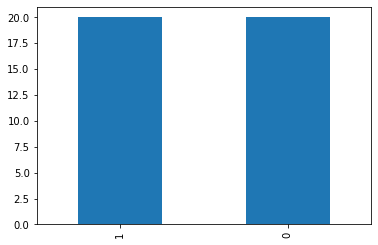

In [111]:
df['label'].value_counts().plot.bar()

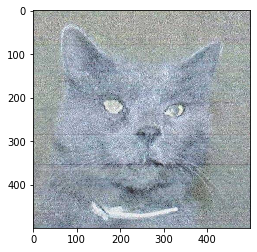

In [112]:
sample_img = random.choice(filenames)
sample_image = load_img('images/split/extra_pred/'+sample_img)
plt.imshow(sample_image)

In [118]:
pred_datagen = ImageDataGenerator(
    rescale=1./255
)
pred_generator = pred_datagen.flow_from_directory(
    directory=pred_dir, 
    class_mode='binary',
    target_size=(299, 299)
)

Found 40 images belonging to 2 classes.


In [128]:
total_pred = df.shape[0]

In [134]:
total_pred

40

In [140]:
Y_val = df['label']
y_pred =  model.predict_generator(pred_generator, steps=2)

In [146]:
len(y_pred)

40

In [143]:
Y_val_int = df['label'].astype('int')

In [144]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1, 0)

In [145]:
df['pred_value'] = np.where(y_pred > threshold, 1,0)

In [152]:
sample_pred = df.sample(n=40).reset_index()
sample_pred.head()

,index,filename,label,pred_value
0,9,cat.3002.jpg,0,0
1,37,dog.3005.jpg,1,1
2,32,cat.3001.jpg,0,0
3,7,cat.3007.jpg,0,1
4,33,cat.3018.jpg,0,1


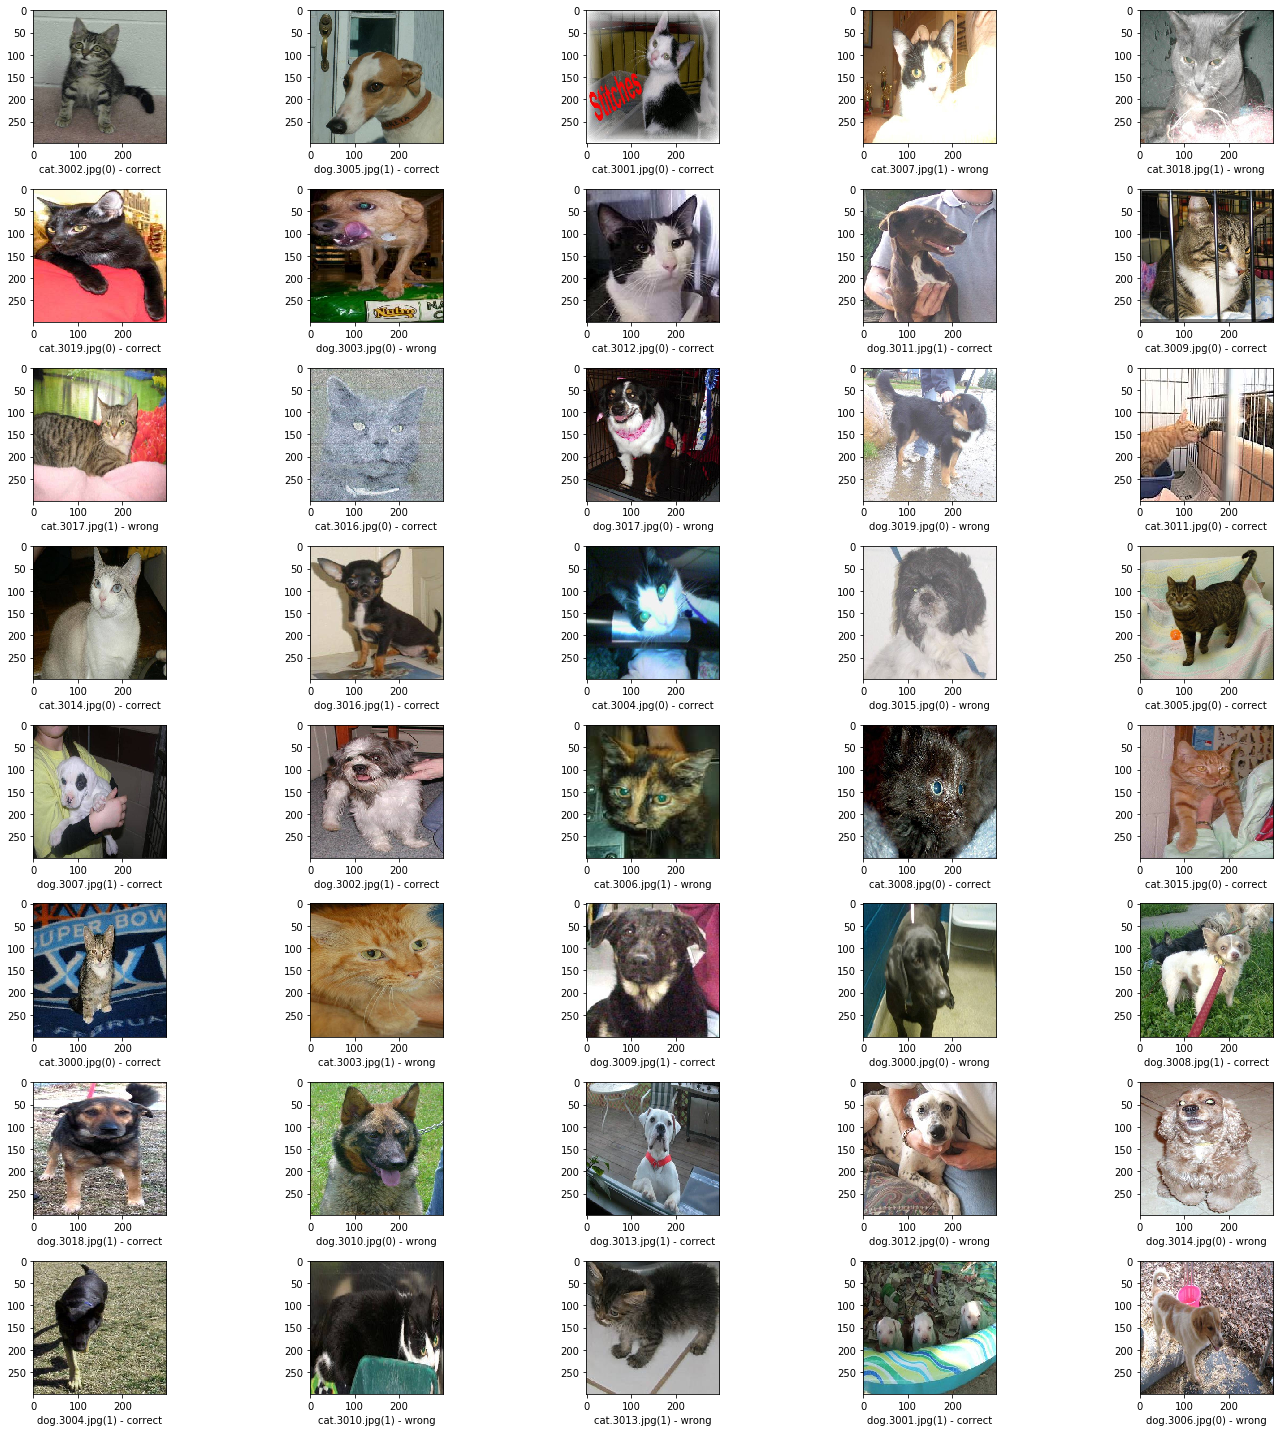

In [154]:
plt.figure(figsize=(20, 20))
for index, row in sample_pred.iterrows():
    filename = row['filename']
    category = row['pred_value']
    real_label = row['label']
    img = load_img('images/split/extra_pred_no_split/'+filename, target_size=(299, 299))
    plt.subplot(8, 5, index+1)
    plt.imshow(img)
    if category == real_label:
        plt.xlabel(filename + '(' + "{}".format(category) + ')' + ' - correct')
    else:
        plt.xlabel(filename + '(' + "{}".format(category) + ')' + ' - wrong')
        
plt.tight_layout()
plt.show()

### Evaluation Metrics

In [155]:
acc = accuracy_score(Y_val_int, y_final)*100
cm = confusion_matrix(Y_val_int, y_final)

print('Acc: ', acc)
print('CM:' )
cm

Acc:  60.0
CM:


array([[13,  7],
       [ 9, 11]], dtype=int64)

========= Confusion Matrix =========


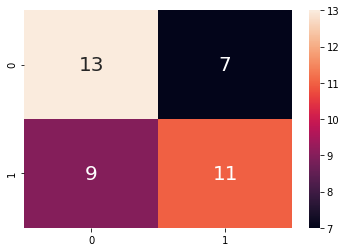


========= Evaluation Metrics =========
Accuracy: 60.000%
Precision: 59.091%
Recall: 65.000%
F1-score: 61.905%

========= Training Accuracy =========
Train acc: 97.08
FN:  7
Total:  40


In [156]:
tn = cm[1][1]
fp = cm[1][0]
fn = cm[0][1]
tp = cm[0][0]

print('========= Confusion Matrix =========')
sns.heatmap(cm, 
            annot=True,
            fmt='d',
            annot_kws={'size': 20})
plt.show()

print('\n========= Evaluation Metrics =========')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {:.3f}%'.format(acc))
print('Precision: {:.3f}%'.format(precision))
print('Recall: {:.3f}%'.format(recall))
print('F1-score: {:.3f}%'.format(2*precision*recall/(precision+recall)))

print('\n========= Training Accuracy =========')
print('Train acc: {}'.format(np.round((history.history['acc'][-1])*100, 2)))
print('FN: ', fn)
print('Total: ', tn+fp+fn+tp)